In [1]:
from pathlib import Path
import compiler_gym
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import os
import sys
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt
import pdb

from compiler_gym_dataset import CompilerGymDataset, process_networkx_graph
from model_gnn import GNNEncoder

device = 'cpu'

Using backend: pytorch


In [2]:
root_path = os.environ.get("COMPILER2_ROOT")
db_path = Path(root_path + "/results/random-compiler2-v0/2022-05-03/12-44-11/1569317/results_0.pkl")

print(db_path)
print(f"Is file good = {db_path.is_file()}")

/home/dx4/tools/compiler2/results/random-compiler2-v0/2022-05-03/12-44-11/1569317/results_0.pkl
Is file good = True


In [3]:
env = compiler_gym.make("llvm-v0")
print(f'Number of actions = {len(env.action_space.flags)}')

Number of actions = 124


./compiler_gym-llvm-service: /lib64/libtinfo.so.5: no version information available (required by ./compiler_gym-llvm-service)


In [4]:
columns = ["BenchmarkName", "State", "NextState", "Action", "CommandLine", "Reward"]
# df = pd.read_csv(db_path, names=columns, header=1)
with open(db_path, 'rb') as f:
    df = pickle.load(f)[:10]

df.loc[:, 'StatePerf'] = df['State'].map(lambda x: x[0])
df.loc[:, 'StatePrograml'] = df['State'].map(lambda x: x[1])

df.loc[:, 'NextStatePerf'] = df['NextState'].map(lambda x: x[0])
df.loc[:, 'NextStatePrograml'] = df['NextState'].map(lambda x: x[1])


state_min = np.min(np.stack(df['StatePerf']),0)
state_max = np.max(np.stack(df['StatePerf']),0)
df['StatePerf'] = df['StatePerf'].apply(lambda x: (x-state_min)/(state_max-state_min+1e-9))
df['StatePerf'] = df['StatePerf'].apply(lambda x:torch.tensor(x).float())

state_min = np.min(np.stack(df['NextStatePerf']),0)
state_max = np.max(np.stack(df['NextStatePerf']),0)
df['NextState'] = df['NextStatePerf'].apply(lambda x: (x-state_min)/(state_max-state_min+1e-9))
df['NextStatePerf'] = df['NextStatePerf'].apply(lambda x:torch.tensor(x).float())


action_kinds = pd.Categorical(df['Action'], categories=env.action_space.flags)
action_one_hot = pd.get_dummies(action_kinds)

df = df.dropna()
df['Action'] = action_one_hot.values.tolist()
df['Action'] = df['Action'].apply(lambda x: torch.tensor(x).float())
df['Reward'] = df['Reward'].apply(lambda x: torch.tensor(x).float())

df.head()

,BenchmarkName,State,NextState,Action,CommandLine,Reward,StatePerf,StatePrograml,NextStatePerf,NextStatePrograml
0,benchmark://poj104-v0/28_982,"[[354630.0, 1171172.0, 0.55, 273553.0, 0.0, 0....","[0.5445832773523199, 0.0, 0.0, 0.0109890109888...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....",opt -lower-guard-intrinsic -die -mergeicmps -s...,tensor(-0.2822),"[tensor(0.1639), tensor(0.3485), tensor(0.6667...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[tensor(454690.), tensor(1022230.), tensor(0.4...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,benchmark://poj104-v0/28_982,"[[454690.0, 1022230.0, 0.45, 273545.0, 0.0, 0....","[0.10207272238711133, 0.14862988406711308, 0.4...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....",opt -lower-guard-intrinsic -die -mergeicmps -s...,tensor(0.2390),"[tensor(0.6505), tensor(0.), tensor(0.), tenso...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[tensor(346001.), tensor(1099511.), tensor(0.5...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
2,benchmark://poj104-v0/28_982,"[[419822.0, 1290683.0, 0.59, 273544.0, 0.0, 0....","[0.030087248950610376, 0.5599204548077135, 0.9...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....",opt -lower-guard-intrinsic -die -mergeicmps -s...,tensor(0.2180),"[tensor(0.4810), tensor(0.6281), tensor(0.9333...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[tensor(328320.), tensor(1313364.), tensor(0.6...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
3,benchmark://poj104-v0/28_982,"[[328320.0, 1313364.0, 0.6, 273545.0, 0.0, 0.0...","[0.05980807673673429, 0.6456969435875332, 0.99...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....",opt -lower-guard-intrinsic -die -mergeicmps -s...,tensor(-0.0222),"[tensor(0.0359), tensor(0.6812), tensor(1.), t...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[tensor(335620.), tensor(1357964.), tensor(0.6...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
4,benchmark://poj104-v0/28_982,"[[345772.0, 1250643.0, 0.56, 273634.0, 0.0, 0....","[0.8371298637320369, 0.5548604112655676, 0.874...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....",opt -nary-reassociate -simple-loop-unswitch -m...,tensor(-0.5228),"[tensor(0.1208), tensor(0.5344), tensor(0.7333...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[tensor(526545.), tensor(1310733.), tensor(0.5...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


In [5]:
experience_dataset = CompilerGymDataset(df, device=device)
experience_dataset.data.head()

Create vocabulary


,BenchmarkName,State,NextState,Action,CommandLine,Reward,StatePerf,StatePrograml,NextStatePerf,NextStatePrograml
0,benchmark://poj104-v0/28_982,"[[354630.0, 1171172.0, 0.55, 273553.0, 0.0, 0....","[0.5445832773523199, 0.0, 0.0, 0.0109890109888...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....",opt -lower-guard-intrinsic -die -mergeicmps -s...,tensor(-0.2822),"[tensor(0.1639), tensor(0.3485), tensor(0.6667...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[tensor(454690.), tensor(1022230.), tensor(0.4...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,benchmark://poj104-v0/28_982,"[[454690.0, 1022230.0, 0.45, 273545.0, 0.0, 0....","[0.10207272238711133, 0.14862988406711308, 0.4...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....",opt -lower-guard-intrinsic -die -mergeicmps -s...,tensor(0.2390),"[tensor(0.6505), tensor(0.), tensor(0.), tenso...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[tensor(346001.), tensor(1099511.), tensor(0.5...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
2,benchmark://poj104-v0/28_982,"[[419822.0, 1290683.0, 0.59, 273544.0, 0.0, 0....","[0.030087248950610376, 0.5599204548077135, 0.9...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....",opt -lower-guard-intrinsic -die -mergeicmps -s...,tensor(0.2180),"[tensor(0.4810), tensor(0.6281), tensor(0.9333...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[tensor(328320.), tensor(1313364.), tensor(0.6...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
3,benchmark://poj104-v0/28_982,"[[328320.0, 1313364.0, 0.6, 273545.0, 0.0, 0.0...","[0.05980807673673429, 0.6456969435875332, 0.99...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....",opt -lower-guard-intrinsic -die -mergeicmps -s...,tensor(-0.0222),"[tensor(0.0359), tensor(0.6812), tensor(1.), t...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[tensor(335620.), tensor(1357964.), tensor(0.6...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
4,benchmark://poj104-v0/28_982,"[[345772.0, 1250643.0, 0.56, 273634.0, 0.0, 0....","[0.8371298637320369, 0.5548604112655676, 0.874...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....",opt -nary-reassociate -simple-loop-unswitch -m...,tensor(-0.5228),"[tensor(0.1208), tensor(0.5344), tensor(0.7333...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[tensor(526545.), tensor(1310733.), tensor(0.5...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


In [6]:
model = GNNEncoder(
    # Add one to the vocab size to accomodate for the out-of-vocab element.
    node_vocab_size=len(experience_dataset.vocab['text']) + 1,
    node_hidden_size=64,
)

In [7]:
import dgl
import numpy as np
import torch
from dgl.data import DGLDataset

In [8]:
test_size = len(df) // 5
train_size = len(df) - test_size

print(f'Dataset training validation = {test_size}, {train_size}')
train_set, test_set = torch.utils.data.random_split(experience_dataset, [train_size, test_size])

batch_size = 1
trainLoad = DataLoader(train_set,batch_size=batch_size,shuffle=True, collate_fn=experience_dataset.collate_fn,)
testLoad = DataLoader(test_set,batch_size=batch_size,shuffle=True, collate_fn=experience_dataset.collate_fn,)
policy_net = model.to(device)
target_net = model.to(device)

target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(policy_net.parameters())
train_losses = []
test_losses = []
num_epochs = 1
test_every = 5
gamma = 0.9

Dataset training validation = 2, 8


In [17]:
for epoch in tqdm(range(num_epochs)):
    # loop_inner = tqdm(total=train_size//batch_size,position=0,leave=False)
    policy_net.train()
    for S, A, R, S_ in trainLoad:
        # S, A, R, S_ = data

        for S, A, R, S_ in zip(S, A, R, S_):
            r = torch.sum(torch.mul(policy_net(S),A), 1)
            r_hat = 1 + torch.max(target_net(S_), 1).values * gamma
                    
            loss = criterion(r,r_hat)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_losses.append(loss.item())
        #     loop_inner.set_description('epoch:{}, loss:{:.4f}'.format(epoch, loss.item()))
        #     loop_inner.update(1)
        # loop_inner.close()

        if epoch % test_every == 0:
            with torch.no_grad():
                policy_net.eval()
                for S,A,R,S_ in trainLoad:
                    for S, A, R, S_ in zip(S, A, R, S_):

                        r = torch.sum(torch.mul(policy_net(S),A),1)
                        r_hat = R + torch.max(target_net(S_),1).values * gamma

                        loss = criterion(r,r_hat)
                        test_losses.append(loss.item())
        target_net.load_state_dict(policy_net.state_dict())


100%|██████████| 1/1 [00:00<00:00,  2.60it/s]


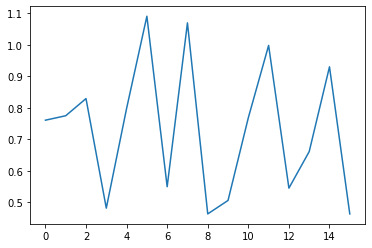

In [18]:
plt.figure(facecolor='white')
plt.plot(train_losses)

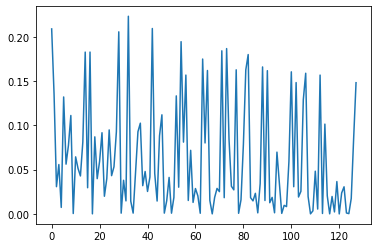

In [19]:
plt.figure(facecolor='white')
plt.plot(test_losses)

In [20]:
def get_action(state,network,epsilon):
    p = random.random()
    if p > epsilon:
        with torch.no_grad():
            return torch.max(network(state),1).indices[0].item()
    else:
        return random.randint(0,124)

In [21]:
get_action(df['StatePrograml'].iloc[0],target_net,1)

32

In [22]:
df['StatePrograml'].iloc[0]

In [23]:
get_action(process_networkx_graph(df['StatePrograml'][0], experience_dataset.vocab), target_net,0)

49

In [24]:

output_pt_path = db_path.parent/'deep_q.pt'
model_scripted = torch.jit.script(target_net) # Export to TorchScript
model_scripted.save(output_pt_path) # Save

print(f"Saved at: {output_pt_path}")

RuntimeError: Can't redefine method: forward on class: __torch__.model_gnn.GNNEncoder (of Python compilation unit at: 0x56461f1dee00)